# DHS Data Preprocessing

- Harmonized data is here:
- https://docs.google.com/document/d/1So35M9Y9hSjligvYfas1Owb8ZjmbRjhRrjWIk9vp9yI/edit?tab=t.0

In [1]:
import geopandas as gpd
import os

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
country = 'KHM'

In [4]:
os.chdir('/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@sig-gis.com/My Drive/DISES/batched-predictions-branch')

In [5]:
data_folder = 'data/'

In [6]:
file_path = os.path.join(data_folder, 'KHM/DHS/sdr_national_data_2024-10-16/shps/sdr_national_data_dhs_2014.shp')

### MPI

In [7]:
years = ['00', '05', '10', '14', '21-22']
year = years[0]

In [9]:
#Path were all mpi shapes are
mpi_folders = '/Users/Daniel/Library/CloudStorage/GoogleDrive-dwiesner@sig-gis.com/.shortcut-targets-by-id/1UFnD8ofHi_4YXqnGCH4FLW8bapLdp4qX/DISES SIG/Dataset Information/MPI/'

In [10]:
mpi = {}

In [11]:
for year in years: 

    #Generate paths and load files
    #Paths
    mpi_folder_file = f'mpi_khm_dhs{year}_hmn_clust_CI_mis/mpi_khm_dhs{year}_hmn_clust_CI_mis.shp'
    file_path = os.path.join(mpi_folders, mpi_folder_file)
    #Load
    mpi[year] = gpd.read_file(file_path)

In [12]:
pcrs = mpi['00'].crs

In [284]:
mpi_stats = {}

from statsmodels.stats.weightstats import DescrStatsW


for year in years: 
    # Create a weighted descriptive statistics object
    year_stats = {} 
    
    df = mpi[year]
    weighted_stats = DescrStatsW(df['mpi'], weights=df['tot_ppl'])
    year_stats['mean'] = weighted_stats.mean
    year_stats['std'] = weighted_stats.std
    year_stats['var'] = weighted_stats.var

    
    mpi_stats[year] = year_stats
    


In [285]:
import pandas as pd

In [286]:
df = pd.DataFrame(mpi_stats)

In [287]:
def plot_mean_std(df):
    # Extract the relevant columns
    time = df.columns  # Assuming the columns represent time intervals
    mean = df.loc['mean']
    std = df.loc['std']

    # Plot the mean
    plt.plot(time, mean, label='Mean', color='blue')

    # Fill between mean ± std
    plt.fill_between(time, mean - std, mean + std, color='blue', alpha=0.2, label='Mean ± 1 STD')

    # Add labels and legend
    plt.xlabel('Year')
    plt.ylabel('MPI')
    plt.title('Mean and Std Cambodia')
    plt.legend()
    
    # Display the plot
    plt.show()

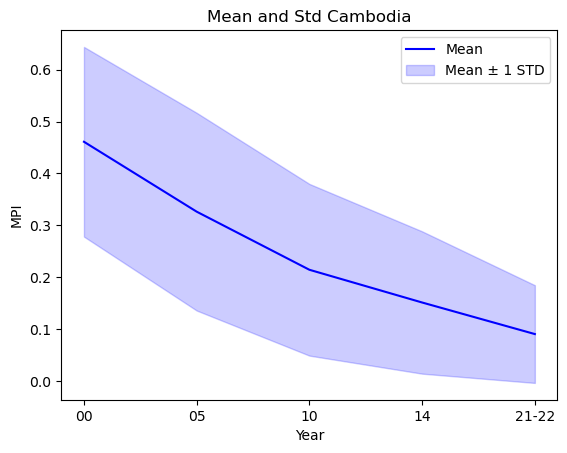

In [288]:
plot_mean_std(df)

In [289]:
df.to_clipboard()

# Treatment and control

In [290]:
# Load the shape file with geographic covariates
initial_shape_path = os.path.join(data_folder, country, 'panel/panel-khm-02082024-v2.shp')
gdf = gpd.read_file(initial_shape_path)
gdf = gdf.to_crs(pcrs)

In [291]:
gdf = gdf[['cf_buffer5', 'geometry']]

In [292]:
mpi['14'].shape

(611, 30)

In [293]:
for year in years:
    mpi[year] = mpi[year].sjoin(gdf)

In [294]:
mpi_stats = {}

for year in years: 
    # Create a dictionary to store stats for the year
    year_stats = {}
    
    df = mpi[year]
    
    # Filter for the 'cf_buffer5' subgroup
    df_t = df[df['cf_buffer5'] == 1]
    
    # Filter for the rest of the data (excluding 'cf_buffer5')
    df_rest = df[df['cf_buffer5'] == 0]
    
    # Weighted statistics for the 'cf_buffer5' subgroup
    if not df_t.empty:
        weighted_stats_t = DescrStatsW(df_t['mpi'], weights=df_t['tot_ppl'])
        year_stats['treatment'] = {
            'mean': weighted_stats_t.mean,
            'std': weighted_stats_t.std,
            'var': weighted_stats_t.var
        }
    
    # Weighted statistics for the rest of the data
    if not df_rest.empty:
        weighted_stats_rest = DescrStatsW(df_rest['mpi'], weights=df_rest['tot_ppl'])
        year_stats['rest'] = {
            'mean': weighted_stats_rest.mean,
            'std': weighted_stats_rest.std,
            'var': weighted_stats_rest.var
        }

    # Store the stats for the current year
    mpi_stats[year] = year_stats


In [295]:
#Get two df fro the data
# Create two dictionaries to store mean and std for treatment and rest
treatment_data = {'mean': [], 'std': [], 'var': []}
rest_data = {'mean': [], 'std': [], 'var': []}
years_list = []  # To keep track of the years

# Populate the dictionaries from mpi_stats_dict
for year, stats in mpi_stats.items():
    years_list.append(year)  # Store the year
    
    # Extract stats for treatment
    if 'treatment' in stats:
        treatment_data['mean'].append(stats['treatment']['mean'])
        treatment_data['std'].append(stats['treatment']['std'])
        treatment_data['var'].append(stats['treatment']['var'])
    else:
        # If treatment data is missing, append None or NaN
        treatment_data['mean'].append(None)
        treatment_data['std'].append(None)
        treatment_data['var'].append(None)

    # Extract stats for the rest
    if 'rest' in stats:
        rest_data['mean'].append(stats['rest']['mean'])
        rest_data['std'].append(stats['rest']['std'])
        rest_data['var'].append(stats['rest']['var'])
    else:
        # If rest data is missing, append None or NaN
        rest_data['mean'].append(None)
        rest_data['std'].append(None)
        rest_data['var'].append(None)

# Convert the dictionaries to DataFrames, with years as columns
df1 = pd.DataFrame(treatment_data, columns=['mean', 'std', 'var'], index=years_list).T
df2 = pd.DataFrame(rest_data, columns=['mean', 'std', 'var'], index=years_list).T

In [296]:

def plot_mean_std(df1, df2, label1='Group 1', label2='Group 2', title='Mean and Std Comparison'):
    # Extract time from the DataFrame columns
    time = df1.columns  # Assuming the columns represent time intervals

    # Extract mean and std for df1 group
    mean_df1 = df1.loc['mean']
    std_df1 = df1.loc['std']

    # Extract mean and std for df2 group
    mean_df2 = df2.loc['mean']
    std_df2 = df2.loc['std']

    # Plot the mean and std for df1
    plt.plot(time, mean_df1, label=f'{label1} Mean', color='blue')
    plt.fill_between(time, mean_df1 - std_df1, mean_df1 + std_df1, 
                     color='blue', alpha=0.2, label=f'{label1} Mean ± 1 STD')

    # Plot the mean and std for df2
    plt.plot(time, mean_df2, label=f'{label2} Mean', color='green')
    plt.fill_between(time, mean_df2 - std_df2, mean_df2 + std_df2, 
                     color='green', alpha=0.2, label=f'{label2} Mean ± 1 STD')

    # Add labels, title, and legend
    plt.xlabel('Year')
    plt.ylabel('MPI')
    plt.title(title)
    plt.legend()
    
    # Show the plot
    plt.show()

# Example usage:
# plot_mean_std(df1, df2, label1='cf_buffer5', label2='Rest', title='Mean and Std of MPI: cf_buffer5 vs Rest')


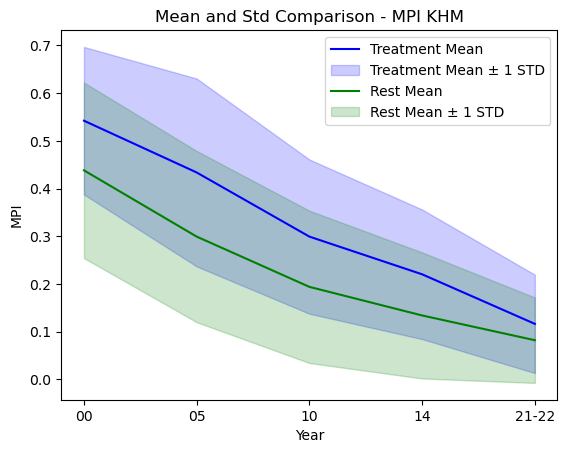

In [297]:
plot_mean_std(df1, df2, label1='Treatment', label2='Rest', title='Mean and Std Comparison - MPI KHM')

### API

In [250]:
indicator_id = 'WS_TLET_H_NFC'
survey_id = 'KH2014DHS'
country_id = 'KH'
data_url = f'https://api.dhsprogram.com/rest/dhs/data?breakdown=all&indicatorIds={indicator_id}&countryIds={country_id}&surveyIds={survey_id}&lang=en&f=json'

In [251]:
# Obtain and Parse the list into a Python Object.
req = urllib.request.urlopen(data_url)  # Use urllib.request in Python 3
resp = json.loads(req.read())  # Parse the response JSON into a Python object
dhs = resp['Data']

Index(['DHSID', 'DHSCC', 'DHSYEAR', 'DHSCLUST', 'CCFIPS', 'ADM1FIPS',
       'ADM1FIPSNA', 'ADM1SALBNA', 'ADM1SALBCO', 'ADM1DHS', 'ADM1NAME',
       'DHSREGCO', 'DHSREGNA', 'SOURCE', 'URBAN_RURA', 'LATNUM', 'LONGNUM',
       'ALT_GPS', 'ALT_DEM', 'DATUM', 'clust_no', 'area', 'region', 'mpi',
       'mpi_SE', 'mpi_lo95CI', 'mpi_up95CI', 'tot_ppl', 'pct_pplmis',
       'geometry'],
      dtype='object')

In [21]:
mpi['21-22'].columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])